# Neural Differential Equations 

In this notebook we will explore Neural Differential Equations (NDEs). The goal is to teach you about the basics of Neural Differential Equations and demonstrate how they can be used to approximate dynamical systems. We will take you through one example of fitting a NDE to a Lotka-Volterra system and prepare you to apply it to another system as your project. 

## Introduction to NDEs 

* With Neural Differential Equations we try to find a way to combine knowledge that we have of systems in form of their governing equations with data-driven approximators such as ANNs

* In fact, there is an analogy between differential equations and ANNs:

* A Residual Network (ResNet) block  is defined by $$\mathbf{h}_{t+1} = \mathbf{h}_t + f(\mathbf{h}_t;\theta_t),$$ where $f$ can be any combination of other neural network layers with parameters $\theta_t$, $\mathbf{h}_t$ is the output of the previous block or layer, which also serves as the input of the ResNet block, $\mathbf{h}_{t+1}$ is its output  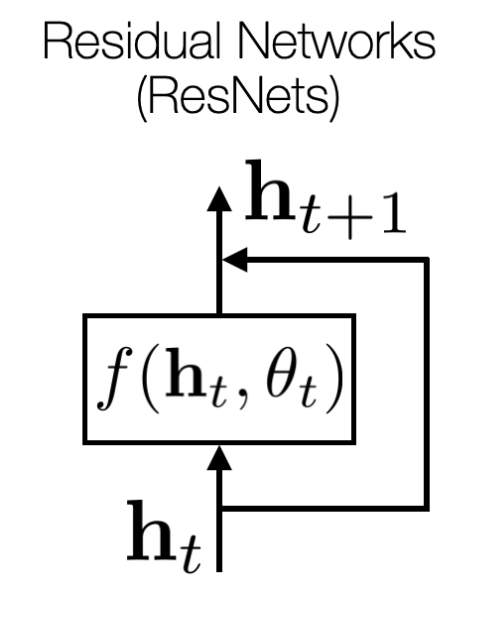

* Through their short cut connection (see the image), ResNets learn a residual (hence the name). They proved to be an effective architecture for a wide variety of problems


* Compare that to the Euler solver that discretized and solves an ODE:
$$\begin{align}  
\frac{d\mathbf{h}(t)}{dt} &= f(\mathbf{h}(t),t;\theta)\\
\mathbf{h}_{t+1} &= \Delta t f(\mathbf{h}_t, t;\theta) + \mathbf{h}_t\\
\end{align}$$

* The Euler solver and the ResNet have almost the same iteration formula 

* Hence, differential equations can be seen as a continuous time limit of ResNet ANNs
* There are several paper that use to just solve ResNets with ODE solvers, but this is not our primary interest
* We will use them to approximate dynamical systems and also a method to incorporate prior knowledge into the ML algorithm

### The Universal Differential Equations Framework

* If we can treat differential equations and ANNs so similar, we just combine them directly:

$$\frac{du}{dt} = f(u,t,U_\theta(u,t)),$$ 
where $U_{\theta}$ is some data-driven function approximator (such as an ANN)
  
![image-2.png](notebook-assets/overview2.png)

* We can integrate these Neural Differential Equations numerically, like any other differential equation we've seen before, resulting in a trajectory $$\hat{\mathbf{u}}(\mathbf{x},t;\theta)$$

* `DiffEqFlux.jl`/`DiffEqSensitivity.jl` are by far the most comprehensive implementation of this approach (of all programming languages)
* `torchdiffeq` offers some of the functionality for pyTorch
* `diffrax` offers some of the functionality for JAX

### How to Train Neural Differential Equations 

* Remember, to train an ANN we usually set a loss function $L(\theta)$ and then minimize this loss on a training data set by doing a gradient descent 

* Given some example trajectories $\mathbf{u}$ as training data, we can define a loss function $$L(\theta)= \sum_{i_t,\mathbf{x}} ( u(\mathbf{x},i_t) - \hat{\mathbf{u}}(\mathbf{x},t;\theta) )^2  + \gamma\sum_i||\theta_i||$$

* The loss function is a sum of the squared differences with an added regularization 

* What do we still need to train? 

* For regular ANNs, we would do a gradient descent by computing $\nabla_\theta L$, but here we have a slightly different situation

* Here $\hat{\mathbf{u}}(\mathbf{x},t;\theta)$ are trajectories, solutions of differential equations 

* How do we take a derivative of solutions of differential equations? 

### Adjoint Sensitivity Problems 

* These kind of problems were already solved before, e.g. by Lev Pontryagin in the 60s, analysing trajectories of rockets, or later in meteorolgy to explore the sensitivity of some climate models 

* There are many different (but vaguely similar) approaches, in Julia `DiffEqSensitivity.jl` implements many of them 




* If you want to see a complete derivation of the algorithm, [click here](notebook-assets/ReverseModeSensitivityAnalysis.html)

* With the approach from [Chen et al](https://arxiv.org/abs/1806.07366): *Reverse-mode adjoint sensitivity analysis*, we can compute derivates of the trajectories  

#### Reverse-mode Adjoint Sensitivity Problem 

In order to compute the derivatives we augment the ODE with adjoints 
\begin{align}
      \mathbf{a}(t) &= \frac{\partial \mathcal{L}}{\partial \mathbf{x}(t)}\\
      \mathbf{a}_\theta(t) &= \frac{\partial\mathcal{L}}{\partial\theta(t)} 
\end{align}

These will help us to compute the additional information that we need for the derivatives. Similar to how a traditional backpropagation traverses the chain of the ANN from the output back to the input, the appended ODE with the adjoint needs to be solved backwards in time as the initial values of the augmented dynamics are only known at the end point of the integration $t_1$. 

To compute $\frac{\partial\mathcal{L}}{\partial\theta}$, we need to solve the appended ODE that include [the dynamics of the adjoints](notebook-assets/ReverseModeSensitivityAnalysis.html).

\begin{align} 
    \begin{pmatrix}
        \frac{d \mathbf{x}}{d t}\\
        \frac{d \mathbf{a}}{d t}\\ 
        \frac{d \mathbf{a}_\theta}{d t}\\
    \end{pmatrix} =
     \begin{pmatrix}
        f(\mathbf{x},t,\theta)\\
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \mathbf{x}(t)} \\ 
        - \mathbf{a}^T(t) \frac{\partial f(\mathbf{x}(t),t,\theta)}{\partial \theta}\label{eq:node-train}
    \end{pmatrix} 
\end{align}
backwards in time from $t_1$ to $t_0$ with initial conditions $[\mathbf{x}(t_1); \frac{\partial\mathcal{L}}{\partial\mathbf{x}(t_1)}; \mathbf{0}]$ to eventually get $\frac{\partial\mathcal{L}}{\partial\theta} = \mathbf{a}_\theta(t_0)$. The partial derivatives are computed using AD. 

## The First Example 

As a first example, we look into fitting a Neural ODE to data that we generate from a Lotka-Volterra system. Then, as your project you will adapt this for chaotic systems and maybe some data! 

## Let's start coding

It's time to start coding, but first, we'll have to do some housekeeping and set up a Julia enviroment with all the packages that we need for our project 

### Setting up the Environment 

* We activate a (new) enviroment similar e.g. to Python's `pyenv` or the enviroments from Conda and add all the packages that we need   
* We can add packages from the central registry just by their name, or from Git repositories
* Julia will precompile these packages the first time they are run, this might take a few minutes

In [1]:
import Pkg # we load the Julia package manager 
Pkg.activate(".") # we activate a (new) environment in the local folder 
Pkg.add("DifferentialEquations") # the package for Differential Equations and its solvers 
Pkg.add("DiffEqSensitivity") # the package that includes all of the sensitivity analysis algorithms 
Pkg.add("Flux") # provides us with ANNs and utility for ANNs 
Pkg.add("Plots") # basic plotting (can also use Python's matplotlib)

Pkg.add(url="https://github.com/maximilian-gelbrecht/NODEData.jl.git") # A small package that may help you with 
# preparing the training data
Pkg.add(url="https://github.com/maximilian-gelbrecht/ChaoticNDETools.jl") # A small package that provides some
# functions for setting up Neural ODEs for chaotic systems 

using DifferentialEquations, DiffEqSensitivity, Flux, Plots, NODEData

  Activating project at `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Nextcloud/ML-DS-Workshop-23/projects/NeuralDifferentialEquations/Project.toml`
  No Changes to `~/Nextclo

### Generate the Training Data 

Our first goal is to fit a Neural ODE to a Lotka Volterra system, modelling predator-prey dynamics. For species of **H**ares and **F**oxes it's given by:
\begin{align}
  \frac{dH}{dt} = \alpha H - \beta H F \\
   \frac{dF}{dt} = -\gamma F + \delta H F.
\end{align}

We implement this system in Julia and solve with a parameter configuration that will lead to oscillations. 

In [2]:
"""
    lotka_volterra(x,p,t)

This is a docstring in Julia, and here we define the right-hand side of the ODE. The right-hand must always 
have the function signature `(x,p,t) -> dx` for an out-of-place definition, or `(dx,x,p,t)` for an inplace, 
mutating function. 
"""
function lotka_volterra(x,p,t)
    α, β, γ, δ = p # this splits a tuple or array into its elements 
    [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end

α = 1.
β = 0.5
γ = 1.
δ = 0.2
p = [α, β, γ, δ] 
tspan = (0.,50.) # this is the time interval we want to integrate our system for 

x0 = [20., 5.] # some initial conditions 

2-element Vector{Float64}:
 20.0
  5.0

With the basic definitions we can use `DifferentialEquations` to integrate the system. 

Per default, the solver will use an adaptive stepsize. This is not really well suitable for most machine learning approaches. Neural DEs can learn from unevenly sampled data, but still it makes things a bit easier to use evenly sampled data. Therefore we instruct the solver to save every 0.1 time steps: 

In [3]:
prob = ODEProblem(lotka_volterra, x0, tspan, p) # we initialize the initial value ODE Problem 
dt = 0.1
sol = solve(prob, saveat=dt) # The DifferentialEquations.jl package will automatically pick a suitable solver

retcode: Success
Interpolation: 1st order linear
t: 501-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
 48.9
 49.0
 49.1
 49.2
 49.3
 49.4
 49.5
 49.6
 49.7
 49.8
 49.9
 50.0
u: 501-element Vector{Vector{Float64}}:
 [20.0, 5.0]
 [16.568987089479915, 6.529916574952113]
 [12.74401812996872, 7.921276987653031]
 [9.226267489338728, 8.919804023384637]
 [6.432516169429118, 9.426433701660281]
 [4.42261808300631, 9.495830654901116]
 [3.055544756324699, 9.250910390166787]
 [2.1484997625783864, 8.812228923250833]
 [1.5486550002679504, 8.270585474743116]
 [1.1484168268841253, 7.686080448273865]
 [0.877047804171973, 7.095762041092393]
 [0.6897120240081471, 6.521149562718761]
 [0.5577757805127656, 5.9742166887281165]
 ⋮
 [1.4008870584336515, 0.1552500959450851]
 [1.5366350468493826, 0.14466232087912378]
 [1.6864109978568829, 0.13517672586202248]
 [1.851641385998824, 0.12670790480533442]
 [2.0338691301443172, 0.11918450590705361]
 [2.234802

In [4]:
Array(sol)

2×501 Matrix{Float64}:
 20.0  16.569    12.744    9.22627  …  3.26644    3.59339    3.95356
  5.0   6.52992   7.92128  8.9198      0.0937579  0.0908547  0.0886484

This returns a solution object that saves all the values of the computed trajectory, in order to plot it we transform it into a regular array with `Array` and take its transpose to have a $(N_t\times 2)$-sized array for plotting:

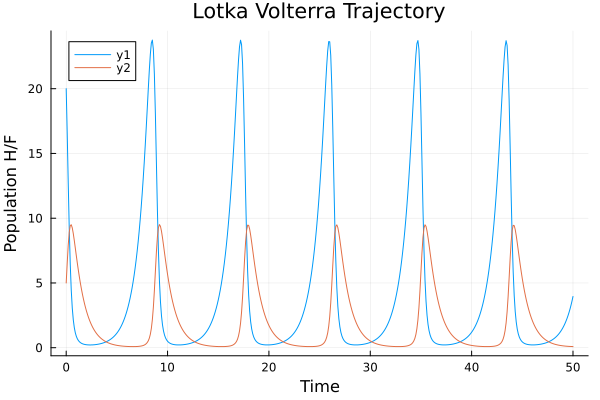

In [5]:
plot(sol.t, Array(sol)', xlabel="Time", ylabel="Population H/F", title="Lotka Volterra Trajectory")

**Tip:** For plotting you can also use the `PyPlot` package which is a wrapper around Python matplotlib and has exactly the same syntax as in Python!

* We'll use the `NODEData` package to slice this trajectory into smaller trajectories of length $N_{length}$ that we can you when training. 

* Espacially later, for chaotic systems, it is important to start with just very small slices of the trajectory, as otherwise the gradient of long trajectories of chaotic systems becames meaningless (small deviations early on, will always result in large deviations of the learned trajectory)

In [6]:
N_length = 10
train, valid = NODEDataloader(sol, N_length; dt=dt, valid_set=0.8)

(NODEData{Matrix{Float64},Int64} with 91 batches with length 10, NODEData{Matrix{Float64},Int64} with 390 batches with length 10)

For our first example, we will use 80% of the trajectory as our validation set and use the first 20% for training our Neural DE (that's the keyword argument `valid_set=0.8`).

We can iterate over the `train` object and it will always return as a tuple `(t, x(t))` with a trajectory of length $N_{length}$

In [7]:
train

NODEData{Matrix{Float64},Int64} with 91 batches with length 10

In [8]:
train[1]

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [20.0 16.568987089479915 … 1.5486550002679504 1.1484168268841253; 5.0 6.529916574952113 … 8.270585474743116 7.686080448273865])

In [9]:
train[1][1]

10-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9

In [10]:
train[1][2]

2×10 Matrix{Float64}:
 20.0  16.569    12.744    9.22627  …  3.05554  2.1485   1.54866  1.14842
  5.0   6.52992   7.92128  8.9198      9.25091  8.81223  8.27059  7.68608

### Artificial Neural Networks 

So, we prepared our training data. Next, we setup an ANN that is supposed to approximate the right hand side of the Lotka Volterra system. We do that with the `Flux.jl` library. For today, we will restrict ourselves to multilayer perceptrons, so layers of the type 

\begin{align}
    \sigma\left(\mathbf{W}x + \mathbf{b}\right),
\end{align}

where $\sigma$ is the nonlinear activation function, and $\mathbf{W}\in\mathbb{R}^{N_{out}\times N_{in}}$ and $\mathbf{b}\in\mathbb{R}^{N_{out}}$ are the learnable paraemters. In Flux these are called `Dense` layers, and initialized simply bei calling `Dense(N_in, N_out, activiation_function)`. We can stack several Dense layers together by using the `Chain` command. 

In [11]:
nn = N_WEIGHTS = 10 
nn = Chain(Dense(2, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 2))

Chain(
  Dense(2 => 10, swish),                # 30 parameters
  Dense(10 => 10, swish),               # 110 parameters
  Dense(10 => 10, swish),               # 110 parameters
  Dense(10 => 2),                       # 22 parameters
)                   # Total: 8 arrays, 272 parameters, 1.562 KiB.

This is the ANN that we will use, we can simply execute it by calling it directly: 

In [12]:
nn([0.4, 0.5])

2-element Vector{Float64}:
  0.008874449259946293
 -0.02154742954993336

For using it in a Neural DE, we need to seperate structure and parameters of the ANN for technical reasons. We can do that like this, and then call the network again: 

In [13]:
p_nn, re_nn = Flux.destructure(nn)
re_nn(p_nn)([0.4, 0.5])

2-element Vector{Float64}:
  0.008874449259946293
 -0.02154742954993336

* `re_nn` contains the information about the structure and reintialized the network with the paremeters `p` when it is called with them. The reinitialized network can then be used as any other ANN again. 

* With all of these set up, in principle, we can treat the Neural ODE like any other ODE and set it up like we did set up the Lotka-Volterra system when generating the data

* For the first example we will set the ANN to approximate the complete rhs of the ODE:
\begin{align}
    \frac{d\mathbf{u}}{dt} = \text{ANN}(\mathbf{u};\theta)
\end{align}

In [15]:
neural_rhs(u,p,t) = re_nn(p)(u)

neural_prob = ODEProblem(neural_rhs, x0, tspan, p_nn)
neural_sol = solve(neural_prob, saveat=dt)

retcode: Success
Interpolation: 1st order linear
t: 501-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮
 48.9
 49.0
 49.1
 49.2
 49.3
 49.4
 49.5
 49.6
 49.7
 49.8
 49.9
 50.0
u: 501-element Vector{Vector{Float64}}:
 [20.0, 5.0]
 [20.366100167743916, 4.86398567872342]
 [20.735878902166508, 4.72222116385539]
 [21.10930527038501, 4.574590633827864]
 [21.486360005956396, 4.42098841435167]
 [21.867029340564216, 4.261312306867043]
 [22.251304681950504, 4.0954632410660246]
 [22.63918261391577, 3.9233452748924615]
 [23.03066489631897, 3.7448655945420253]
 [23.425752842478623, 3.5599360341511117]
 [23.824448496599718, 3.3684623565928535]
 [24.22676949216298, 3.170337498783111]
 [24.632725504667047, 2.9654563120348976]
 ⋮
 [403.51752904309444, -276.0451073112835]
 [405.00133921552816, -277.0914345396238]
 [406.49008108254577, -278.1409456916215]
 [407.9837755690483, -279.1936564102273]
 [409.4824436375148, -280.24958234987173]
 [410.986

But we didn't train the network yet, so the trajetory is meaningless:

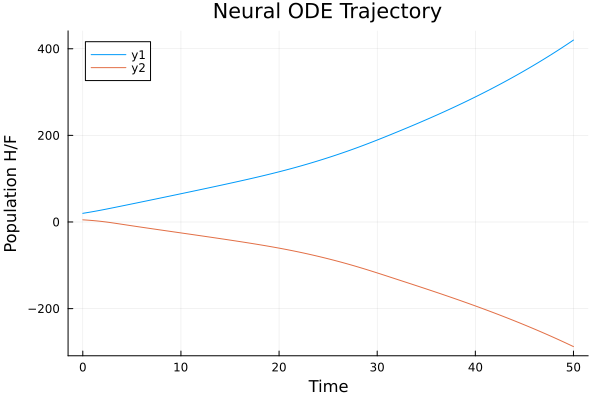

In [16]:
plot(neural_sol.t, Array(neural_sol)', xlabel="Time", ylabel="Population H/F", title="Neural ODE Trajectory")

To train the network, we first define a loss function. For now the least square error
\begin{align}
    L(\theta) = \sum_{i_t}|| \hat{\mathbf{u}}(i_t; \theta) - \mathbf{u}(i_t)||
\end{align}
between the true trajectory $\mathbf{u}$ and the trajectory of our Neural DE $\hat{\mathbf{u}}$. 

In [25]:
loss(x,y) = sum(abs2, x - y)
L = p -> loss(Array(solve(remake(neural_prob; p=p), saveat=dt)), Array(sol))

loss (generic function with 1 method)

* For this defintion of $L(\theta)$ we had to use the `remake` command to always solve the Neural DE with the current parameters

* Then, we can take gradients of this function:

In [27]:
g = gradient(L, p_nn)

(Float32[1.2406137f8, -1.5273654f8, 2.3475572f6, 2.776314f8, -400.49286, 1.6208285f8, 4.579241f7, 2.1459575f6, -8.921657f6, -3.7367944f7  …  4.4043008f8, 3.5516758f8, -1.40997f6, -1.9552198f6, 1.8388582f6, 3.998479f6, -2.2086248f6, -2.853283f6, 4.1232452f7, 3.7858204f7],)

The first time we execute a gradient call it will take long time, as it needs to assemble and compile the gradient code. All subsequent executions are much faster! This returns a tuple of which `g[1]` is the desired $\frac{dL}{d\theta}$:

In [28]:
g[1]

272-element Vector{Float32}:
      1.2406137f8
     -1.5273654f8
      2.3475572f6
      2.776314f8
   -400.49286
      1.6208285f8
      4.579241f7
      2.1459575f6
     -8.921657f6
     -3.7367944f7
     -1.1981287f8
      5.582379f7
 399945.75
      ⋮
  -3638.1504
  -5319.95
      4.4043008f8
      3.5516758f8
     -1.40997f6
     -1.9552198f6
      1.8388582f6
      3.998479f6
     -2.2086248f6
     -2.853283f6
      4.1232452f7
      3.7858204f7

We could use this to build up an optimization loop and train our Neural DE like this. However, we will use some predefined functions that will also make it easier to apply it to chaotic systems:

* `ChaoticNDE` provides a easily trainable model that behaves similar to the ANN from Flux, we can call .
    * If you want to know more about the implemenation of this model, [click here](notebook-assets/ChaoticNDE.ipynb)

In [29]:
model = ChaoticNDE(neural_prob)



LoadError: UndefVarError: ChaoticNDE not defined

In [26]:
L(p_nn)

3.0262604312914032e7

# look at how to do it without the struct???

explain it with just initializing the solution -> then using the ChaoticNDE package 

## Project Suggestions 

### Fit a (hybrid) Lorenz system

### Work with PDEs 

### Fit it to data 

### What roles in the group could you assign? 

* `Data preperation`

* `

## References 

* [Chen et al, 2018: Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366)
* [Rackauckas et al, 2020: Universal Differential Equations for Scientific Machine Learning](https://arxiv.org/abs/2001.04385) / `DiffEqFlux.jl`
* [Gelbrecht et al, 2021: Neural partial differential equations for chaotic systems](https://iopscience.iop.org/article/10.1088/1367-2630/abeb90)
